In [ ]:
from google.colab import drive

# Mount Google Drive to access the dataset
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load libraries
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation
#from keras.layers.core import Flatten, Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
#from keras.layers.normalization import BatchNormalization
#from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import optimizers
from sklearn.preprocessing import LabelEncoder
#from keras.utils import np_utils
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
train_path = '/content/drive/MyDrive/MONKEYPOX Disease/Fold1/Fold1/Fold1/Train'

train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(115,115),
                                                         classes=['Monkeypox','Non Monkeypox'], class_mode='categorical',
                                                         batch_size=27560)

imgs, label = next(train_batches)
print(label.shape)
print(imgs.shape)

Found 980 images belonging to 2 classes.
(980, 2)
(980, 115, 115, 3)


In [ ]:
# We need to separate the data into train and test arrays
X_train, X_test, y_train, y_test = train_test_split(imgs,label,test_size=0.3,random_state=42)

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=10,  # Rotate images randomly
        zoom_range = 0.1, # Zoom images randomly
        width_shift_range=0.1,  # Horizontally shift images in random order
        height_shift_range=0.1  # Vertically shift images in random order
)

datagen.fit(X_train)

Monkeypox


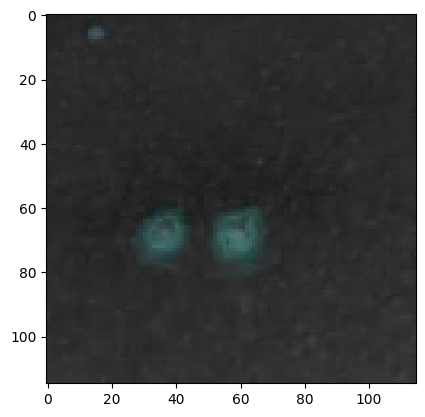

Monkeypox


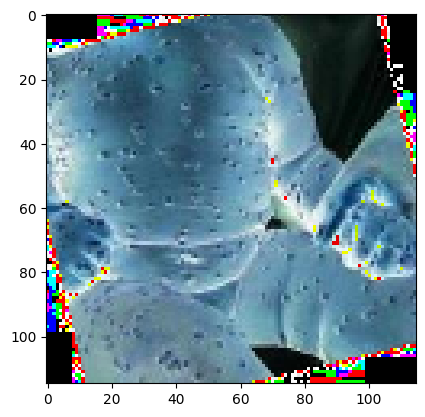

Monkeypox


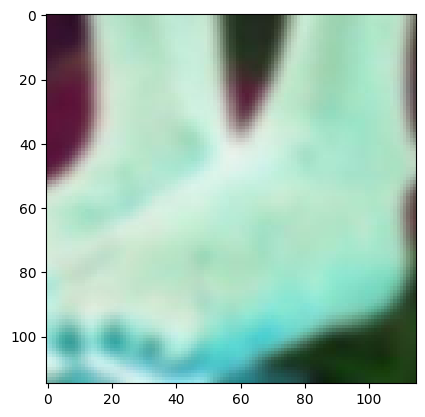

Monkeypox


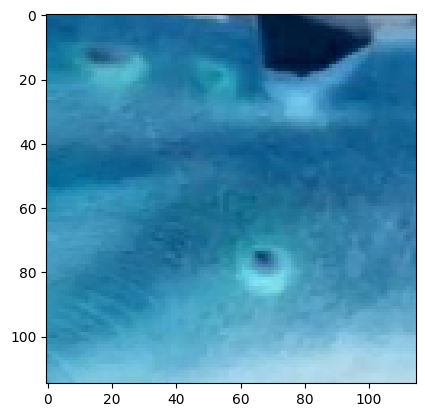

Monkeypox


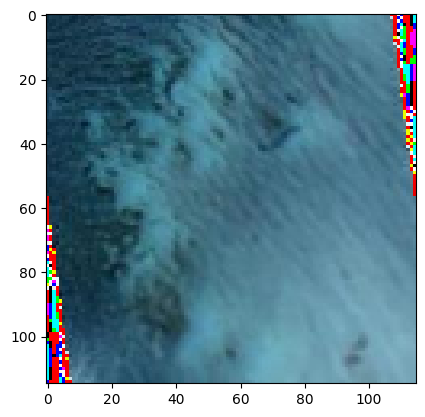

In [ ]:
for i in range (0,5):
    image = imgs[i]
    plt.imshow((image * 255).astype(np.uint8))
    if (label[i][0]==1):
      print("Monkeypox")
    if (label[i][1]==1):
        print("Non Monkeypox")
    plt.show()

In [ ]:
def show_confusion_matrix(history, model, x_test, y_test):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Predict class probabilities
    predicted_probabilities = model.predict(x_test)

    # Determine the class with the highest probability for each sample
    predicted_classes = np.argmax(predicted_probabilities, axis=1)

    # Rest of your code for the confusion matrix
    cm1 = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes)
    print('Confusion Matrix : \n')
    print(cm1)


VGG16 Model - All Layers Frozen

In [ ]:
# model1 freeze all layers
# VGG16 pre-trained model
image_w, image_h = 115, 115
model1 = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))
model1.summary()

# Freezing all the layers
for layer in model1.layers[:]:
    layer.trainable = False

# Trainable layers
print("Trainable Layers:")
for i, layer in enumerate(model1.layers):
    print(i, layer.name, layer.trainable)

# Adding custom layers to create a new model
new_model = Sequential([
    model1,
    Flatten(name='flatten'),
    Dense(256, activation='relu', name='new_fc1'),
    Dropout(0.5),
    Dense(2, activation='softmax', name='new_predictions')
])
new_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 115, 115, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 115, 115, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 115, 115, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 57, 57, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 57, 57, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 57, 57, 128)       147584    
                                                              

In [ ]:
# Compiling the model - SGD Optimizer
new_model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

#Fitting the model on the train data and labels.
print("Batch Size: 10, Epoch: 5, Optimizer: SGD")
new_model.fit(imgs, label, batch_size=10, epochs=1, verbose=1, validation_split=0.30, shuffle=True)

Batch Size: 10, Epoch: 5, Optimizer: SGD
69/69 [==============================] - 136s 2s/step - loss: 0.0874 - accuracy: 0.9942 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [ ]:
# Compiling the model - Adam Optimizer
new_model.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.0001), metrics=["accuracy"])
#Fitting the model on the train data and labels.
print("Batch Size: 10, Epoch: 5, Optimizer: Adam")
new_model.fit(imgs, label, batch_size=10, epochs=1, verbose=1, validation_split=0.30, shuffle=True)

Batch Size: 10, Epoch: 5, Optimizer: Adam
69/69 [==============================] - 133s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


VGG16 Model - Unfreeze Last Layer

In [ ]:
#Model2 unfreeze last layer
# VGG16 pre-trained model without fully connected layers and with different input dimensions
image_w, image_h = 115, 115
model2 = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))
#model2.summary()

# Freezing the layers except the last one
for i, layer in enumerate(model2.layers):
  layer.trainable = False
  if (i >=15 ):
    layer.trainable = True

for i, layer in enumerate(model2.layers):
    print(i, layer.name, layer.trainable)

# Adding custom layers to create a new model
new_model2 = Sequential([
    model2,
    Flatten(name='flatten'),
    Dense(512, activation='relu', name='new_fc1'),
    Dropout(0.5),
    Dense(2, activation='softmax', name='new_predictions')
])

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
# Compiling the model - SGD Optimizer
new_model2.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

#Fitting the model on the train data and labels.
print("Batch Size: 10, Epoch: 5, Optimizer: SGD")
new_model2.fit(imgs, label, batch_size=10, epochs=1, verbose=1, validation_split=0.30, shuffle=True)

Batch Size: 10, Epoch: 5, Optimizer: SGD
69/69 [==============================] - 157s 2s/step - loss: 0.3092 - accuracy: 0.9854 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


VGG16 Model - All Layers Trainable

In [13]:
#Model2 unfreeze last layer
# VGG16 pre-trained model without fully connected layers and with different input dimensions
image_w, image_h = 115, 115
model2 = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))
#model2.summary()

# Freezing the layers except the last one
for i, layer in enumerate(model2.layers):
  layer.trainable = True

for i, layer in enumerate(model2.layers):
    print(i, layer.name, layer.trainable)

# Adding custom layers to create a new model
new_model2 = Sequential([
    model2,
    Flatten(name='flatten'),
    Dense(512, activation='relu', name='new_fc1'),
    Dropout(0.5),
    Dense(2, activation='softmax', name='new_predictions')
])

0 input_3 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [14]:
# Compiling the model - Adam Optimizer
new_model2.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.00001), metrics=["accuracy"])

#Fitting the model on the train data and labels.
print("Batch Size: 10, Epoch: 5, Optimizer: Adam")
new_model2.fit(imgs, label, batch_size=10, epochs=1, verbose=1, validation_split=0.30, shuffle=True)

Batch Size: 10, Epoch: 5, Optimizer: Adam
69/69 [==============================] - 388s 6s/step - loss: 0.1994 - accuracy: 0.9898 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


ResNet 50 Model - All Layers Trainable

In [15]:
image_w, image_h = 115, 115
model = keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(image_w, image_h, 3))

model.summary()
    # Adding custom layers to create a new model
new_model2 = Sequential([
    model,
    Flatten(name='flatten'),
    Dense(512, activation='relu', name='new_fc1'),
    Dropout(0.5),
    Dense(2, activation='softmax', name='new_predictions')
])
#new_model2.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 115, 115, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 121, 121, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 58, 58, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 58, 58, 64)           256       ['conv1_conv[0][0]']          
 on)                      

In [16]:
# Compiling the model - Adam Optimizer
new_model2.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.00001), metrics=["accuracy"])
es = keras.callbacks.EarlyStopping(monitor='val_acc', verbose=1, mode='max', patience=2)

<ipython-input-17-ca60e26d915a>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model2.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=1, validation_data=(X_test, y_test), verbose=1, steps_per_epoch=X_train.shape[0] // batch_size, callbacks=[es])


6/6 [==============================] - ETA: 0s - loss: 0.1351 - accuracy: 0.9433 

6/6 [==============================] - 207s 29s/step - loss: 0.1351 - accuracy: 0.9433 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Batch Size: 20, Epoch: 1, Optimizer: Adam


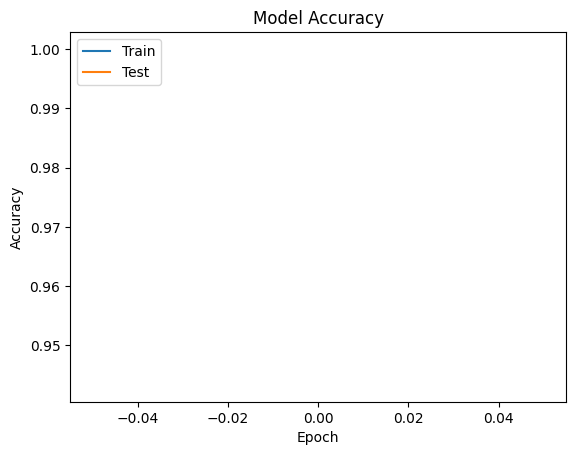

10/10 [==============================] - 15s 1s/step
Confusion Matrix : 

[[294]]


In [17]:
# Fitting the model on the train data and labels.
batch_size = 100
history = new_model2.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=1, validation_data=(X_test, y_test), verbose=1, steps_per_epoch=X_train.shape[0] // batch_size, callbacks=[es])

print("Batch Size: 20, Epoch: 1, Optimizer: Adam")

show_confusion_matrix(history, new_model2, X_test, y_test)

Densenet 121 - All Layers Trainable

In [18]:
image_w, image_h = 115, 115
model = keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=(image_w, image_h, 3))

for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)
model.summary()
    # Adding custom layers to create a new model
new_model2 = Sequential([
    model,
    Flatten(name='flatten'),
    Dense(512, activation='relu', name='new_fc1'),
    Dropout(0.5),
    Dense(2, activation='softmax', name='new_predictions')
])
#new_model2.summary()

29084464/29084464 [==============================] - 0s 0us/step
0 input_5 True
1 zero_padding2d True
2 conv1/conv True
3 conv1/bn True
4 conv1/relu True
5 zero_padding2d_1 True
6 pool1 True
7 conv2_block1_0_bn True
8 conv2_block1_0_relu True
9 conv2_block1_1_conv True
10 conv2_block1_1_bn True
11 conv2_block1_1_relu True
12 conv2_block1_2_conv True
13 conv2_block1_concat True
14 conv2_block2_0_bn True
15 conv2_block2_0_relu True
16 conv2_block2_1_conv True
17 conv2_block2_1_bn True
18 conv2_block2_1_relu True
19 conv2_block2_2_conv True
20 conv2_block2_concat True
21 conv2_block3_0_bn True
22 conv2_block3_0_relu True
23 conv2_block3_1_conv True
24 conv2_block3_1_bn True
25 conv2_block3_1_relu True
26 conv2_block3_2_conv True
27 conv2_block3_concat True
28 conv2_block4_0_bn True
29 conv2_block4_0_relu True
30 conv2_block4_1_conv True
31 conv2_block4_1_bn True
32 conv2_block4_1_relu True
33 conv2_block4_2_conv True
34 conv2_block4_concat True
35 conv2_block5_0_bn True
36 conv2_block5_0_

In [19]:
# Compiling the model - Adam Optimizer
new_model2.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.00001), metrics=["accuracy"])
es = keras.callbacks.EarlyStopping(monitor='val_acc', verbose=1, mode='max', patience=2)

<ipython-input-20-1feafae23ded>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model2.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=1, validation_data = (X_test, y_test), verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size, callbacks=[es])


6/6 [==============================] - ETA: 0s - loss: 0.1825 - accuracy: 0.9215 

6/6 [==============================] - 171s 21s/step - loss: 0.1825 - accuracy: 0.9215 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Batch Size: 20, Epoch: 1, Optimizer: Adam


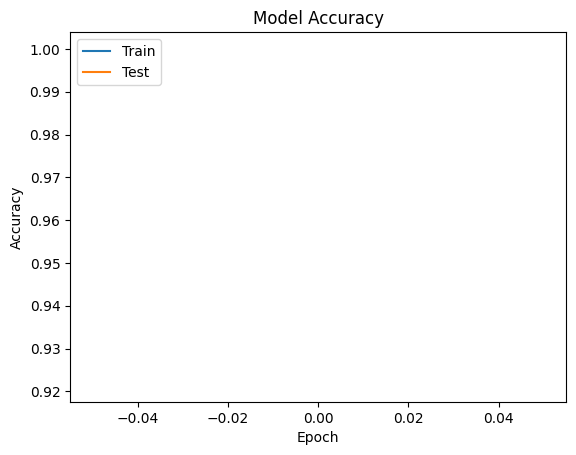

10/10 [==============================] - 12s 962ms/step
Confusion Matrix : 

[[294]]


In [20]:
#Fitting the model on the train data and labels.
batch_size = 100
history = new_model2.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=1, validation_data = (X_test, y_test), verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size, callbacks=[es])
print("Batch Size: 20, Epoch: 1, Optimizer: Adam")
show_confusion_matrix(history,new_model2, X_test, y_test)

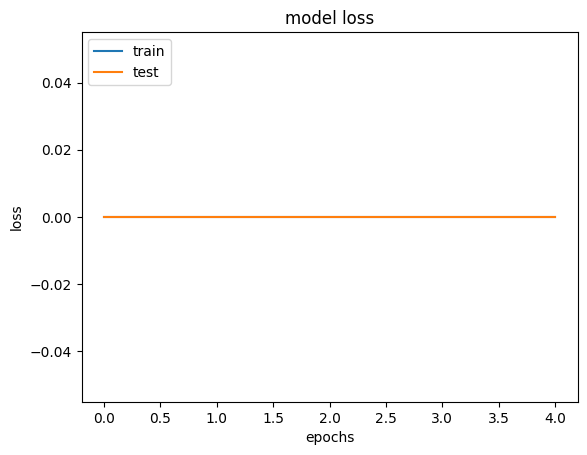

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()